### Robust Experiment on Small data and Q-matrix
1. Fix one region A and a pre-calculated Q-matrix :$Q_0$
2. Pick the $k$ most active regions w.r.t. A through a day (on average) (having the  highest inflow or outflow to/from A based on $Q_0$)
3. Calculate the robust $(k+1)\times(k+1)$ sub-matrix from $Q_0$, call it $Q_s$
4. Plug $Q_s$ into $Q_0$, call the new full-matrix $Q'$
5. Evaluate the overall and $(k+1)$ sub-region performance between $Q_0$ and $Q'$ new via real-data simulation.

### Experiment setup:
- Fix region 224 in NYC, this is Stuyvesant Town-Peter Cooper Village, a lively neighborhood of Manhattan.
- We use the FHVHV vehicle data in 2025 Jan and 2024 Dec (business days only) as the training data. We will divide one day into 4 blocks: 0am-6am, 6a-12pm, 12pm-6pm, 6pm-0am.

- We use 6-hour lookahead policy ($Q^{(6)}$) since each block has 6 hours
- We use $k$ = 10, so the sub-matrix $Q_s$ is $4\times 11\times 11$
- We use $10$ business days from 2025 Jan as $10$ scenarios
- $N=8000$

In [2]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from tqdm.notebook import trange, tqdm
from collections import defaultdict
from matplotlib import pyplot as plt
import time

from constants import (
    location_id_to_index,
    get_region_trip_distribution
)
np.set_printoptions(suppress=True)
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



--- Loading Consolidated Data ---
(24, 234, 234)


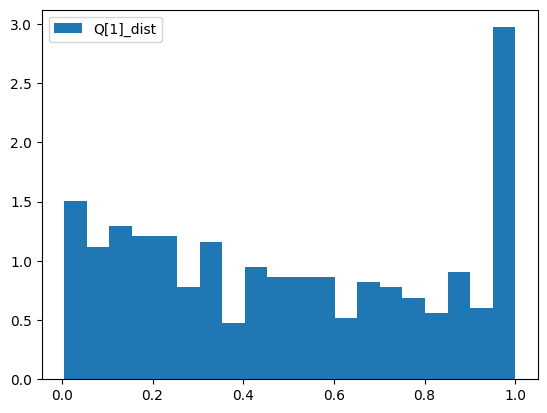

Data loaded successfully.
(24, 234, 234)
all-region arrival rate w.r.t. N:
 [2.10233929 1.29740179 0.88481548 0.77883036 1.01129464 1.44289881
 2.43164286 3.89142857 4.79256548 4.07063393 3.43984524 3.23410417
 3.2858125  3.43403869 3.7671131  3.86478274 4.04823512 4.66197917
 4.86303274 4.6931875  4.34337202 4.11745536 3.99993452 3.51303274]


In [ ]:
Delta = 60 # in minutes
N = 8000 
print("\n--- Loading Consolidated Data ---")
data_filename = "2Months24_trip_data_.npz"
mu_filename = "2Months24_mu.npz"
Q_filename = "Qs_24_2hrLkahd_N8000.npz"

try:
    with np.load(data_filename) as data:
        trip_counts = data['trip_counts']
        num_dates = data['num_dates'].item()
        loaded_all_trip_times_flat = data['all_trip_times']
        loaded_key_counts = data['key_counts']
    with np.load(mu_filename) as data:
        mu = data['mu']
    with np.load(Q_filename) as data:
        Q = data['Q']
        print(Q.shape) #time block x (regions x regions)
        positiveQ = Q[1][Q[1] > 0] #see entries at time block no.2
        entries = positiveQ .flatten()
        plt.hist(entries,density=True,bins=20,label='Q[1]_dist')
        plt.legend()
        plt.show()
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"Error: Consolidated data file {data_filename} not found. Cannot proceed with tasks.")
    exit()

# mask trip_counts by 1 where 0
trip_counts[trip_counts == 0] = 1
print(trip_counts.shape)
# compute arrival rate
lambda_ = trip_counts.sum(axis=2) / (Delta / 60 * num_dates)

''' This step is IMPORTANT '''
lambda_ = lambda_ / N
print('all-region arrival rate w.r.t. N:\n',lambda_.sum(axis=1))
# normalize trip_counts
P = trip_counts / trip_counts.sum(axis=2, keepdims=True)





In [55]:
# # Example: Get distribution for region ID 224 (a common one in NYC)
target_region_id = 224
mapped_target_id = location_id_to_index[target_region_id]

outgoing_dist, incoming_dist, top_10_regions = get_region_trip_distribution(
    target_region_id,
    trip_counts, 
    location_id_to_index
)
if outgoing_dist is not None:
    print(f"\n--- Trip Distribution for Region ID {target_region_id} ({mapped_target_id}) ---")
    print("\nOutgoing Trips:")
    # Sort for better readability (optional)
    sorted_outgoing = sorted(outgoing_dist.items(), key=lambda item: item[1], reverse=True)
    for target_id, count in sorted_outgoing[:3]:
        print(f"  To Region {target_id}: {count} trips")

    print("\nIncoming Trips:")
    # Sort for better readability (optional)
    sorted_incoming = sorted(incoming_dist.items(), key=lambda item: item[1], reverse=True)
    for source_id, count in sorted_incoming[:3]:
        print(f"  From Region {source_id}: {count} trips")

    print(f"\nTop 10 (mapped) Interacting Regions (Total Incoming + Outgoing):")
    for region_id, total_count in top_10_regions:
         print(f"  Region {region_id}: {total_count} total trips")


--- Trip Distribution for Region ID 224 (196) ---

Outgoing Trips:
  To Region 121: 2333 trips
  To Region 71: 2295 trips
  To Region 152: 2295 trips

Incoming Trips:
  From Region 71: 2028 trips
  From Region 121: 1845 trips
  From Region 206: 1723 trips

Top 10 (mapped) Interacting Regions (Total Incoming + Outgoing):
  Region 71: 4323 total trips
  Region 121: 4178 total trips
  Region 152: 3908 total trips
  Region 206: 3751 total trips
  Region 115: 3674 total trips
  Region 94: 2993 total trips
  Region 144: 2982 total trips
  Region 143: 2872 total trips
  Region 98: 2759 total trips
  Region 99: 2656 total trips


In [ ]:
saveP_name = "P24_11slice_normal.npz"
saveMu_name = "mu24_11slice.npz"
saveLam_name = "Lam24_11slice.npz"
saveQ_name = "Q24_11slice.npz"
'''Slicing Lambda, Q, P, mu'''
ind_list = [mapped_target_id] + [i[0] for i in top_10_regions]
ind_map = {i : ind for i,ind in enumerate(ind_list)}
ind_2d = np.ix_(ind_list,ind_list)
# replacing nan's to 1
mu[np.isnan(mu)] = 1

lam_slice = lambda_[:,ind_list]
Q_slice = Q[:, ind_2d[0], ind_2d[1]]
P_slice = P[:,ind_2d[0], ind_2d[1]]
mu_slice = mu[:,ind_2d[0], ind_2d[1]]
for k in range(Q.shape[0]):
    for i in range(len(ind_list)):
        assert(lambda_[k,ind_list[i]] - lam_slice[k,i] == 0)
        for j in range(len(ind_list)):
            assert(Q[k,ind_list[i],ind_list[j]] - Q_slice[k,i,j] == 0)
            assert(P[k,ind_list[i],ind_list[j]] - P_slice[k,i,j] == 0)
            # print(mu[k,ind_list[i],ind_list[j]], mu_slice[k,i,j])
            assert(mu[k,ind_list[i],ind_list[j]] - mu_slice[k,i,j] == 0)
print("--- Data slicing complete ---")
out = [(key, val) for key, val in ind_map.items()]
print('data row/col order:\n',out) 

Ps_normal  = P_slice / P_slice.sum(axis=2, keepdims=True)
np.savez_compressed(saveP_name, P=Ps_normal)
np.savez_compressed(saveMu_name, mu=mu_slice) 
np.savez_compressed(saveLam_name, lam=lam_slice)
np.savez_compressed(saveQ_name, Q=Q_slice)
print("--- Sliced data saved ---") 

--- Data slicing complete ---
data row/col order:
 [(0, 196), (1, 71), (2, 121), (3, 152), (4, 206), (5, 115), (6, 94), (7, 144), (8, 143), (9, 98), (10, 99)]
--- Sliced data saved ---


In [53]:
# Map back to ind
ind_map

{0: 196,
 1: 71,
 2: 121,
 3: 152,
 4: 206,
 5: 115,
 6: 94,
 7: 144,
 8: 143,
 9: 98,
 10: 99}